In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import sys
import time
import seaborn as sns
import pandas as pd
import cupy as cp

from tomo_encoders.tasks.digital_zoom import *
from tomo_encoders import viewer
from utils import *
import numexpr as ne
from tomo_encoders.misc.phantom_generators import get_sub_vols_elliptical_voids

In [2]:
V_cpu = np.ones((1024,1024,1024), dtype = np.uint8)
n_voids_gt = 350000
patch_size = (8,8,8)
p = Grid(V_cpu.shape, width = 8, n_points = n_voids_gt)
y = get_sub_vols_elliptical_voids(patch_size, len(p), ellipse_range = (1.5, 1.8), rad_range = (1,8))
sizes_gt = np.cbrt(np.sum(y, axis = (1,2,3)))
print(f"fraction of voids with unit size: {np.sum(sizes_gt==1)/np.size(sizes_gt)}")

fraction of voids with unit size: 0.05806


In [3]:
p.fill_patches_in_volume(y, V_cpu)

In [4]:
V_cpu = V_cpu + np.random.normal(0, 0.2, V_cpu.shape).astype(np.float32)

In [6]:
def binarize(V_cpu, strategy):
    print(f"STRATEGY: {strategy}")
    t_gpu = TimerGPU("secs")
    memory_pool = cp.cuda.MemoryPool()
    cp.cuda.set_allocator(memory_pool.malloc)
    
    V = cp.array(V_cpu, cp.float32)

    if "gaussian" in strategy:
        V[:] = ndimage.gaussian_filter(V,0.5)

    # binarize
    voxel_values = get_values_cyl_mask(V[::2,::2,::2], 1.0).get()
    rec_min_max = modified_autocontrast(voxel_values, s=0.01)
    thresh = cp.float32(threshold_otsu(voxel_values))    
    V[:] = (V<thresh).astype(cp.uint8)        

    if "median" in strategy:
        V[:] = ndimage.median_filter(V, 3)        
    
    return V.get()

In [7]:
# def label_func(V_cpu, strategy):
    
#     # connected components labeling
#     t_gpu.tic()
#     V = cp.array(V, dtype = cp.uint32)
#     V[:], n_det = ndimage.label(V,structure = cp.ones((3,3,3),dtype=cp.uint8))    
#     voids_b = Voids().count_voids(V.get(), b)    
#     t_label = t_gpu.toc('LABELING')

#     voids_b["rec_min_max"] = rec_min_max
#     voids_b.compute_time = {"reconstruction" : 0.0, "labeling" : t_label}

#     del V
#     cp.fft.config.clear_plan_cache(); memory_pool.free_all_blocks()            
#     return np.cbrt(voids_b["sizes"])

In [9]:
strategies = ["raw", "median", "gaussian", "median gaussian"]
size_dict = {}
for strategy in strategies:
    V_seg = binarize(V_cpu, strategy)
    break

STRATEGY: raw


In [12]:
yp = p.extract(V_seg)

STRATEGY: raw
	STAT: voids found - 5469308
	TIME: LABELING 61.92 secs
STRATEGY: median
	STAT: voids found - 155360
	TIME: LABELING 7.08 secs
STRATEGY: gaussian
	STAT: voids found - 162057
	TIME: LABELING 8.87 secs
STRATEGY: median gaussian
	STAT: voids found - 155438
	TIME: LABELING 7.50 secs


In [7]:
def print_stats(size_arr, desc):
    msg = []
    msg.append(f"\n{desc}: {size_arr.size};")
    i = 1; msg.append(f"> {i} pixels: {np.sum(size_arr>i)};")
    msg.append(f"perc of 1 pixel voids: {np.sum(size_dict[desc] == 1)/np.size(size_dict[desc]):.2f}")
    print("".join(msg))
    return
for strategy in strategies:
    print_stats(size_dict[strategy], strategy)


raw: 5469308;> 1 pixels: 589387;perc of 1 pixel voids: 0.89

median: 155360;> 1 pixels: 155316;perc of 1 pixel voids: 0.00

gaussian: 162057;> 1 pixels: 160521;perc of 1 pixel voids: 0.01

median gaussian: 155438;> 1 pixels: 155188;perc of 1 pixel voids: 0.00


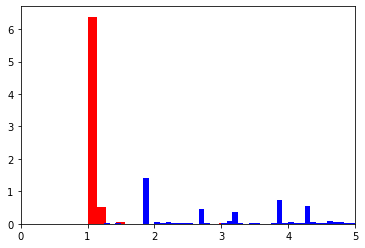

In [8]:
fig, ax = plt.subplots(1,1)
colors = ["red", "blue", "green", "black"]
for i, strategy in enumerate(strategies):
    if i >=2:
        continue
    h = ax.hist(size_dict[strategy], color = colors[i], bins = 500, density = True)
    ax.set_xlim([0,5])